In this file I start by implementing a compressed sensing reconstruction approach. I want to have a well accepted classical method 
as a baseline for my later deep learning models.

In [1]:
import os
import sys

os.environ["CUDA_VISIBLE_DEVICES"]= '2' #, this way I would choose GPU 3 to do the work

sys.path.append('../scripts')
sys.path.append('../models')

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from data_preparation import *
from data_undersampling import *
from Naive_CNN_3D import *
from output_statistics import *
import plotly.graph_objects as go

In [2]:
acceleration_factor = 5

Fully_Sampled = np.load('Ground_Truth/Full_Rank/P03-P08_truncated_k_space.npy')
    
print(Fully_Sampled.shape)
MASKS = np.load('masks.npy')

(22, 22, 21, 96, 8, 6)


1. Generate mask for spherical k-space

In [3]:
nx, ny, nz = 22, 22, 21
fixed_radius = 10

fixed_sphere_mask = fully_sampled_mask(fixed_radius,(nx, ny, nz))

sampled_point = np.sum(fixed_sphere_mask)

print("Number of sampled point")
print(sampled_point)

FT = fourier_transform(Fully_Sampled)
undersampled_FT = FT.copy()

Number of sampled point
4169


In [4]:
r_min = 0
r_max = 10

masks = []

for i in range(0,8):
    mask = create_possoin_undersampling_mask(r_min, r_max, acceleration_factor, fixed_sphere_mask)
    masks.append(mask)
    
masks = np.array([masks[0],masks[1],masks[2],masks[3],masks[4],masks[5],masks[6],masks[7]])

supermask = np.logical_or.reduce(masks, axis=0).astype(np.uint8) ## saves if any of the inputs is non 0

print(np.sum(supermask)/4169)

Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
Real AF:
4.9988009592326135
0.7073638762293116


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


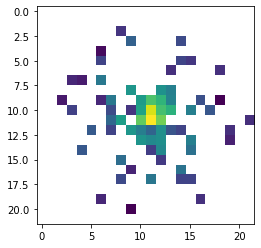

In [5]:
#### Apply mask
FT = fourier_transform(Fully_Sampled)
undersampled_FT = FT.copy()
undersampled_FT_uncombined = FT.copy()

for i in range(0,96):
    for j in range(0,8):
        for k in range(0,undersampled_FT.shape[-1]):
            undersampled_FT[:,:,:, i, j, k] = undersampled_FT[:,:,:, i, j, k] * masks[j]
            undersampled_FT_uncombined[:,:,:, i, j, k] = undersampled_FT_uncombined[:,:,:, i, j, k] * masks[0]

NN_input_uncombined = inverse_fourier_transform(undersampled_FT_uncombined)
NN_input_uncombined = NN_input_uncombined.astype(np.complex64)

NN_input_uncombined_complementary_masks = inverse_fourier_transform(undersampled_FT).astype(np.complex64)
filename = f'Undersampled_Data/Possoin/AF_{acceleration_factor}/Complementary_Masks/data.npy'

# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Only save if the file does not already exist
if not os.path.exists(filename):
    np.save(filename, NN_input_uncombined_complementary_masks)
else:
    print(f"File '{filename}' already exists. Skipping save.")

plt.imshow(np.log10(np.abs(undersampled_FT[:,:,10,0,0,0])))

# Construct the filename

filename = f'Undersampled_Data/Possoin/AF_{acceleration_factor}/One_Mask/data.npy'

# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)

# Only save if the file does not already exist
if not os.path.exists(filename):
    np.save(filename, NN_input_uncombined)
else:
    print(f"File '{filename}' already exists. Skipping save.")

In [6]:
### Alternative: Give mean average value of non-zero entries (from other time steps) to values that are 0

#FT = fourier_transform(ground_truth)     # (X, Y, Z, 96, 8, 2)
#undersampled_FT = FT.copy()

# If your 8 masks are in a list: masks[0], ..., masks[7], first stack them along axis=0
# so you have a single array of shape (8, X, Y, Z).
# e.g., masks_array = np.stack(masks, axis=0)

masks_array = np.stack(masks, axis=0)    # shape: (8, X, Y, Z)

# Loop over your extra dimensions (here: i in [0..96), k in [0..2))
for i in range(96):
    for k in range(undersampled_FT.shape[-1]):
        # Extract data across all 8 time steps at once
        # shape is (X, Y, Z, 8)
        data_slice = undersampled_FT[:, :, :, i, :, k]

        # Transpose so time dimension is first: shape becomes (8, X, Y, Z)
        data_slice_t = np.transpose(data_slice, (3, 0, 1, 2))

        # data_slice_t and masks_array now have matching shapes: (8, X, Y, Z)

        #---------------------------------------------------------------
        # 1) Calculate the mean over only the time steps where mask=1
        #---------------------------------------------------------------
        sum_vals   = np.sum(data_slice_t * masks_array, axis=0)  # shape (X, Y, Z)
        count_vals = np.sum(masks_array, axis=0)                 # shape (X, Y, Z)

        # Avoid dividing by zero (in case all time steps for a voxel are zero)
        mean_vals = sum_vals / np.maximum(count_vals, 1e-8)      # shape (X, Y, Z)

        #---------------------------------------------------------------
        # 2) Fill time steps that are zero in the mask with the mean
        #---------------------------------------------------------------
        # 2) Fill time steps that are zero in the mask with the mean
        zero_mask = (masks_array == 0)  # shape (8, X, Y, Z)

        # Expand mean_vals to (1, X, Y, Z)
        mean_vals_4d = mean_vals[None, ...]  # shape (1, X, Y, Z)

        # Broadcast to (8, X, Y, Z)
        mean_vals_4d = np.broadcast_to(mean_vals_4d, data_slice_t.shape)

        # Now assign where mask = 0
        data_slice_t[zero_mask] = mean_vals_4d[zero_mask]

        #---------------------------------------------------------------
        # 3) Put data back in the original (X, Y, Z, 8) layout
        #---------------------------------------------------------------
        data_slice_filled = np.transpose(data_slice_t, (1, 2, 3, 0))
        undersampled_FT[:, :, :, i, :, k] = data_slice_filled

# Now undersampled_FT has the "averaged fill" for zero-mask voxels
NN_input = inverse_fourier_transform(undersampled_FT)
NN_input = NN_input.astype(np.complex64)

filename = f'Undersampled_Data/Possoin/AF_{acceleration_factor}/Single_Combination/data.npy'


# Ensure the directory exists
os.makedirs(os.path.dirname(filename), exist_ok=True)
# Only save if the file does not already exist
if not os.path.exists(filename):
    np.save(filename, NN_input)
else:
    print(f"File '{filename}' already exists. Skipping save.")


Visualizing mask

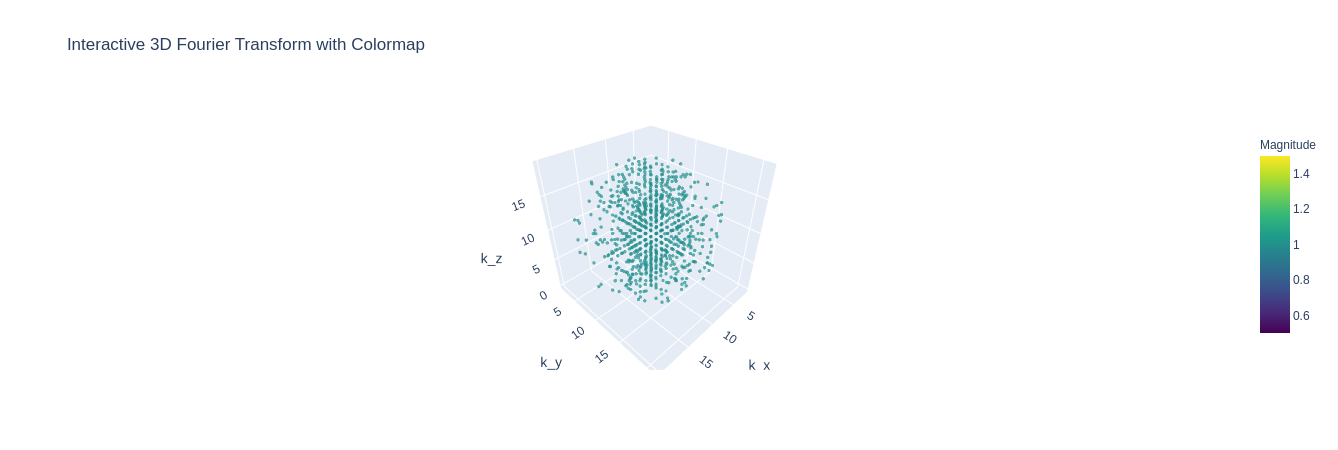

In [7]:
# Suppose 'mask' is your 3D array with 0/1 values.

MASK = masks[0]

#MASK = np.log10(0.000000000001+np.abs(undersampled_FT[:,:,:,0,0,0]))

# Get the indices for the full 3D grid
x, y, z = np.indices(MASK.shape)

# Flatten the arrays
x = x.flatten()
y = y.flatten()
z = z.flatten()
values = MASK.flatten()

# Filter out the 0 values — keep only those indices where values == 1
idx = np.where(values == 1)
x = x[idx]
y = y[idx]
z = z[idx]
values = values[idx]  # This will be all 1's now, but you might still want it for the colormap

# Create the 3D scatter plot
fig = go.Figure(
    data=go.Scatter3d(
        x=x,
        y=y,
        z=z,
        mode='markers',
        marker=dict(
            size=2,              # Adjust marker size
            color=values,        # All ones, but you can still pass it in if you want a colormap
            colorscale='Viridis',
            colorbar=dict(
                title="Magnitude",
                len=0.8
            ),
            opacity=0.7
        )
    )
)

# Update layout for better visualization
fig.update_layout(
    scene=dict(
        xaxis_title="k_x",
        yaxis_title="k_y",
        zaxis_title="k_z",
    ),
    title="Interactive 3D Fourier Transform with Colormap"
)

fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in log10



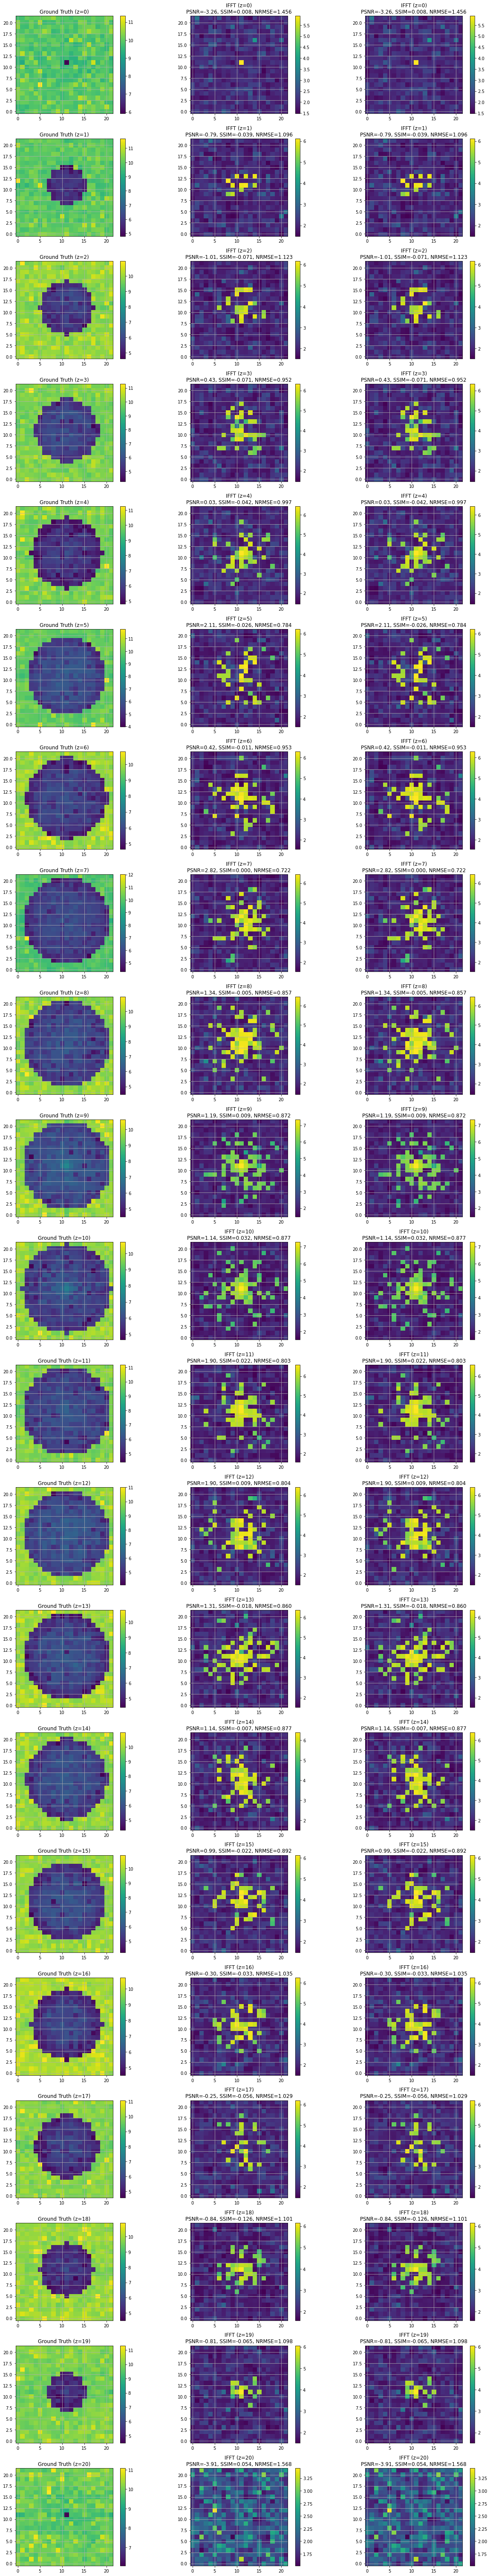

In [8]:
Patient = 4
label = "IFFT"

domain = "time"

NN_input_uncombined_FT = np.log10(np.abs(fourier_transform(NN_input_uncombined)))
Fully_Sampled_FT = np.log10(np.abs(fourier_transform(Fully_Sampled)))


t = 4
T = 7

comparison_Plot_3D_vs_Ifft(NN_input_uncombined_FT[...,Patient], Fully_Sampled_FT[...,Patient], NN_input_uncombined_FT[...,Patient], t, T, domain=domain, label = label)

# ***Undersampling error vs noise error***

**Estimate Signal P07**

    Signal ~ LowRank(Full_Rank_P07, 8)
    
**Estimate equivalent noise**

    noise_2 = Full_Rank_P08 - LowRank(Full_Rank_P08, 8)
    
    That the noise variances of P07 and P08 are basically identical: 11400789 (P07) and 11372949 (P08)
    
**Define noise equivalent ground truth 2:**

    ground_truth_2 = LowRank(Full_Rank_P07, 8) + noise_2

In [9]:
#Checked that noise variance of patient P08 and P07 agrees to more than 99%
Rank = 8

Ground_Truth_1 = Fully_Sampled[...,-2]

Signal = low_rank(Ground_Truth_1, Rank)

#### Generate physically equivalent ground truth, by taking the noise from the last patient; checkt that variance of both patiens agrees
#### to more than 99%!

noise_2 = Fully_Sampled[...,-1] - low_rank(Fully_Sampled[...,-1], Rank)

#### Generate equivalent ground truth

Ground_Truth_2 = Signal + noise_2

####Undersampled Ground_Truth_1
Undersampled = NN_input_uncombined[..., -2]

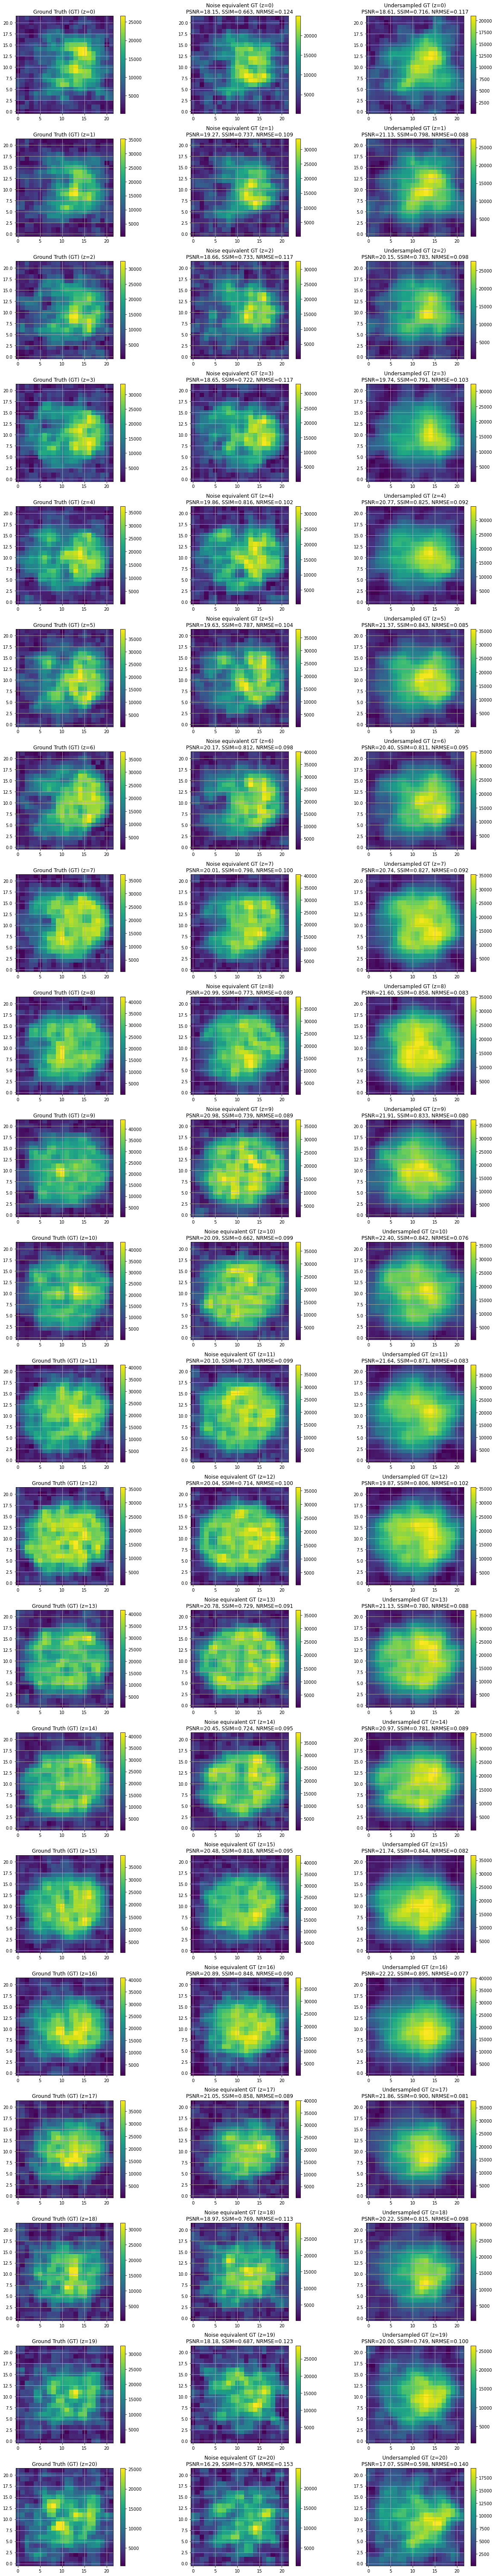

In [10]:
label = "Noise equivalent GT"
label2 = "Undersampled GT"
label3 = "Ground Truth (GT)"

domain = "time"


t = 1 # 50 water peak, ~60 Glc
T = 7

comparison_Plot_3D_vs_Ifft(Ground_Truth_2, Ground_Truth_1, Undersampled, t, T, domain=domain, label = label, label2 = label2, label3 = label3)

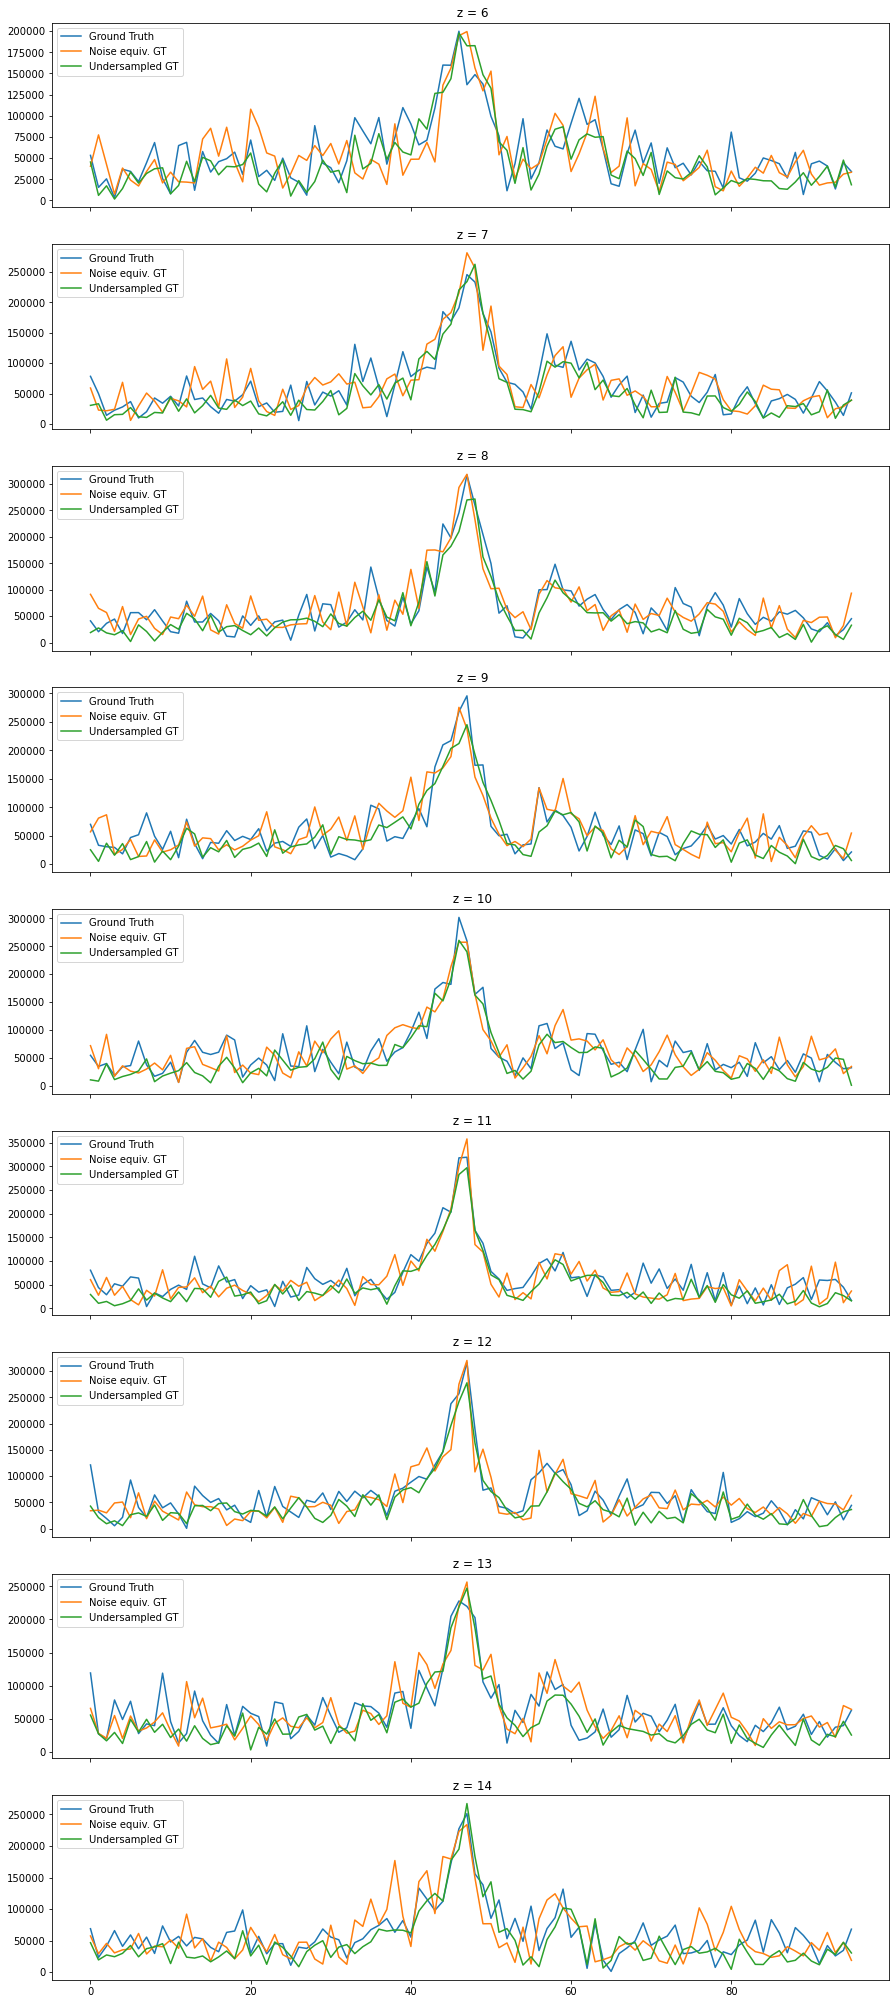

In [11]:
Patient = 0
x, y, T = 10, 10, 5

Ground_Truth_1_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth_1, axis=-2),axes=-2)
Ground_Truth_2_Spectral = np.fft.fftshift(np.fft.fft(Ground_Truth_2, axis=-2),axes=-2)
Undersampled_Spectral = np.fft.fftshift(np.fft.fft(Undersampled, axis=-2),axes=-2)

indices = range(6, 15) 
num_rows = len(indices)
num_cols = 1  # left column: arr1 vs arr2; right column: arr3 vs arr4
# Create a figure and a grid of subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 4), sharex=True)

# If there's only one row, axs may not be 2D, so ensure we have a 2D array:
if num_rows == 1:
    axs = np.array([axs])

for i, idx in enumerate(indices):
    # Left subplot: compare arr1 and arr2
    ax_left = axs[i]
    ax_left.plot(np.abs(Ground_Truth_1_Spectral[x, y, idx, :, T]), label="Ground Truth")
    ax_left.plot(np.abs(Ground_Truth_2_Spectral[x, y, idx, :, T]), label="Noise equiv. GT")
    ax_left.plot(np.abs(Undersampled_Spectral[x, y, idx, :, T]), label=f"Undersampled GT")
    ax_left.set_title(f" z = {idx}")
    ax_left.legend()
    ax_left.legend(loc="upper left")